Setup :

In the context of our pair trading, we consider:

- Two assets ($d=2$) with their underlying dynamics but exhibiting predictable joint behavior (pair trading theory).

- The spread between the two assets follows a mean-reverting process.

- No exogenous information $f=\emptyset$ and $\hat{Z}_t=(t,X_t,Y_t)$ where $X_t$ represents our first asset and $Y_t$ the second.

As discussed in the mean-reverting section, the first-order signature trader is sufficient to capture a mean-reverting signal. The reasoning here will thus be similar to that applied in the mean-reverting section. 

Our goal is to capture the inherent signal in the spread $Y_t-X_t$ using signature terms.

Since $d=2$, $\ell=(\ell_1,\ell_2)$, but for consistency, we denote: $\ell=(\ell_X,\ell_Y)$.

And for each $\ell_{i}$, $i \in \{X,Y\}$, its components are $\ell_{i}=(\ell_{i}^{0},\ell_{i}^{1},\ell_{i}^{2},\ell_{i}^{3})$.

We have: $\hat{\mathbb{Z}}_{0,t}^{\leq 1}=\left(\underbrace{1}_{ \text{associated with }  \ell_i^0} ,\begin{bmatrix} \underbrace{t}_{ \text{associated with } \ell_i^1} \\ \underbrace{X_t-X_0 }_{ \text{associated with }  \ell_i^2} \\ \underbrace{Y_t-Y_0 }_{\text{associated with } \ell_i^3} \end{bmatrix} \right)$ 

and $\forall i \in \{X,Y\}$, $\langle \ell_{i}, \mathbb{Z}_{0,t}^{\leq 1} \rangle = {\ell_{i}}^0 \cdot 1 + \ell_{i}^1 \cdot t + \ell_{i}^2  \cdot (X_t-X_0) + \ell_{i}^3 \cdot (Y_t-Y_0)$ (Expression 1).

Intuitively, $\xi_t^1 \approx Y_t-X_t$ and $\xi_t^2 \approx X_t-Y_t$.

To better interpret the functionals resulting from the signature trader during fitting, we expect to have:
- $\ell_i^0\simeq 0$ car $X_0 = Y_0$
- $\ell_i^1\simeq 0$ since these are stationary processes.
- $\ell_i^2 + \ell_i^3 \simeq 0$  since we aim to capture the signal inherent in $Y_t - X_t$ (expand Expression 1 to see more clearly).

### Some useful

In [1]:
import strat
from strat import OU_data
import torch
import useful
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['lines.linewidth'] = 2.5 

seed=2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 1. Get data

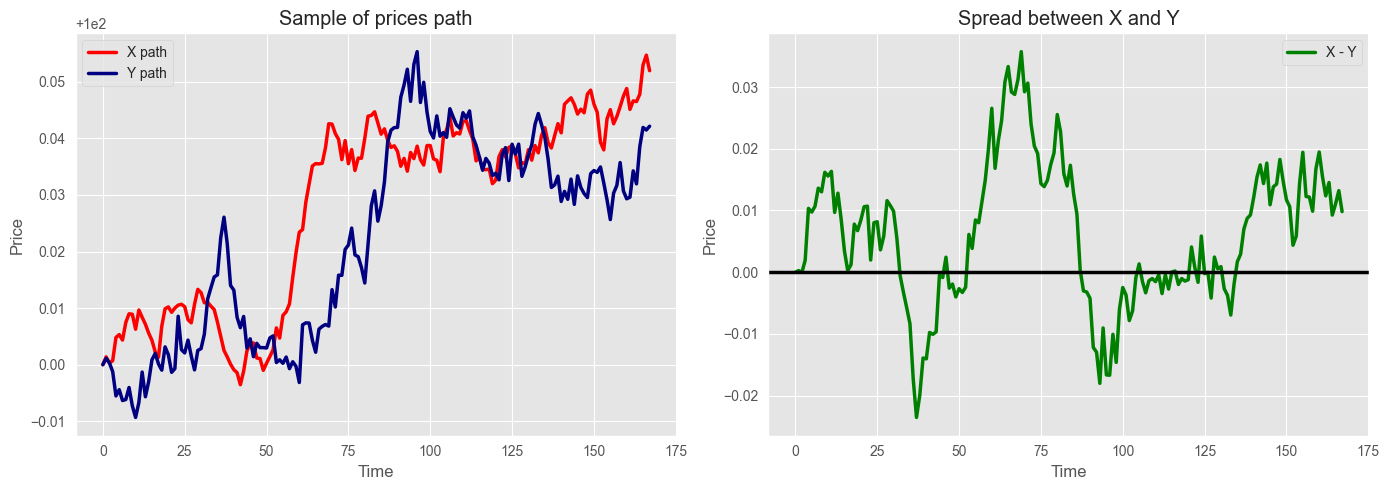

In [2]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

#########
# Params
#########
sigma_X,sigma_Y = 0.1,0.15
k = 150
n_trading_days=252
frequence_of_data=8
rate = n_trading_days*frequence_of_data 
dt = 1/rate # time step
T = 1/12 # number of months / total months in a year
X_0 = 100
Y_0 = 100

batch_len = 30000 
X_Y_paths = OU_data(T, dt, X_0, Y_0, sigma_X, sigma_Y, k,batch_len)
N = X_Y_paths.shape[1] 

exogenous_data = torch.zeros((batch_len, N, 0)) # f = empty

index = random.randint(0, batch_len) # for plot
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].plot(X_Y_paths[index,:,0], label="X path", color='r')
axs[0].plot(X_Y_paths[index,:,1], label="Y path" , color='navy')
axs[0].set_title("Sample of prices path")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price")
axs[0].legend()

axs[1].plot(X_Y_paths[index,:,0] - X_Y_paths[index,:,1], label="X - Y", color='green')
axs[1].axhline(y=0, color='black')
axs[1].set_title("Spread between X and Y")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Price")
axs[1].legend()


workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Pair_trading_sample_path.pdf', format='pdf')

plt.tight_layout()
plt.show()

### 2. Signature trader fitting

In [3]:
# Signature trader fitting
depth = 1
dt = 1 # var(PnL) <= sqrt(delta) (optimization constraint)
Signature_elements = strat.Signature_Trading(depth, dt)
Signature_elements.main_fitting_process(X_Y_paths, exogenous_data)

# deal with mean-reverting property

for func in range(Signature_elements.d):
    Signature_elements.l[func] = -Signature_elements.l[func]


function get_signature runtime is 13.95s
mu_sig is ok
sigma_sig is ok
lambda is ok
l_1
Signature level 0:
tensor([0.5841])
Signature level 1:
tensor([ 1.0461e-03,  5.4907e+03, -5.5326e+03])
l_2
Signature level 0:
tensor([-1.2102])
Signature level 1:
tensor([ 3.8202e-03, -5.4577e+03,  5.7444e+03])
fitting process is ok


### 3. Signature trader in in-sample data

In [4]:
total_trading_assets = 10 # Number of mean-reverting assets involved in trading
pnl_per_assets= torch.zeros(total_trading_assets, N)

for pair_index in range(total_trading_assets):
    
    mean_revert_data = X_Y_paths[pair_index, :, :]
    signal_data = exogenous_data[pair_index, :, :]
    
    # Trading pos. based on signature elements
    xi = Signature_elements.sig_trader(mean_revert_data, signal_data)
    pnl_for_current_asset = Signature_elements.get_PnL(mean_revert_data, xi) # Calculate the hourly PnL for the current asset
    hourly_pnl_pair = torch.sum(pnl_for_current_asset, dim=1)
    pnl_per_assets[pair_index, 1:] = hourly_pnl_pair # Update the PnL for the current pair

total_hourly_pnl = torch.sum(pnl_per_assets, dim=0)
cumulative_pnl_portfolio = torch.cumsum(total_hourly_pnl, dim=0)


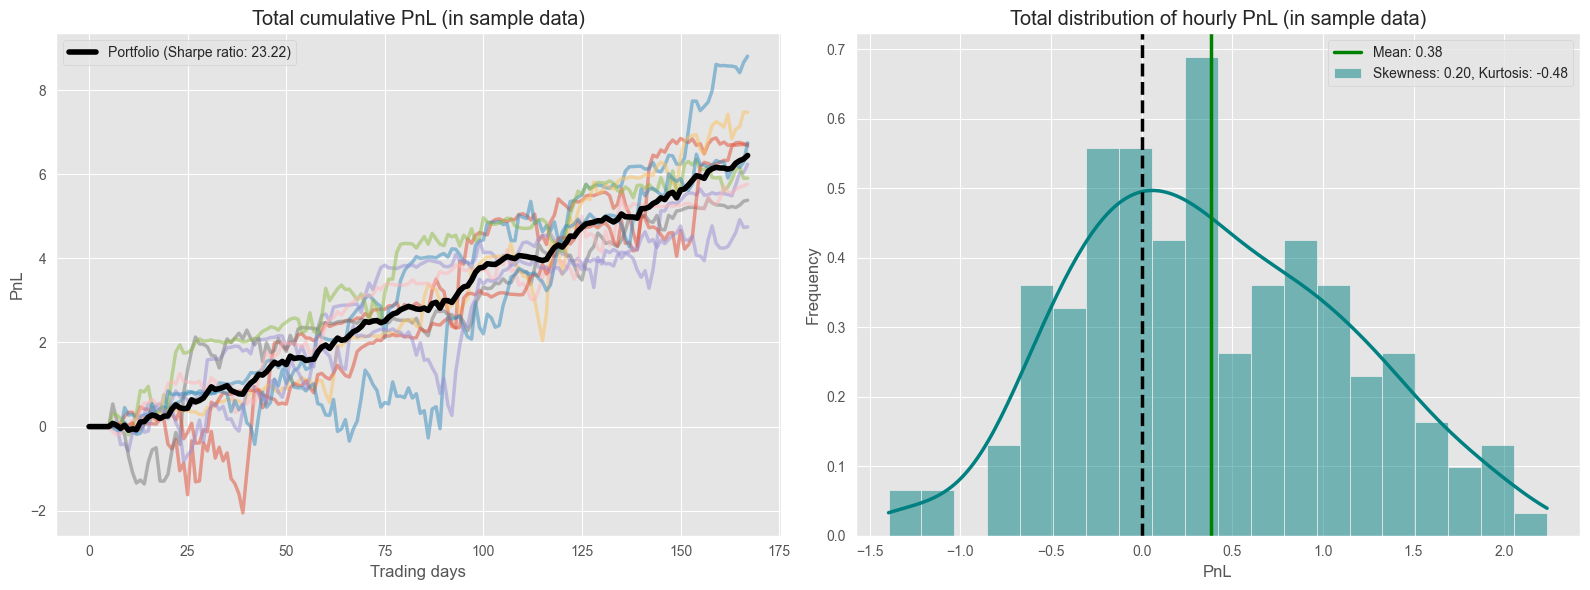

In [7]:
total_trading_assets = len(pnl_per_assets)
total_mean_return = torch.mean(total_hourly_pnl)
total_std_return = torch.std(total_hourly_pnl)
total_sharpe_ratio = total_mean_return / total_std_return * np.sqrt(rate)


norm_ptf_cum_pnl = cumulative_pnl_portfolio / total_trading_assets
H_pnl_mean = torch.mean(total_hourly_pnl)
H_pnl_std = torch.std(total_hourly_pnl)
H_pnl_skew = torch.mean((total_hourly_pnl - H_pnl_mean)**3) / H_pnl_std**3
H_pnl_kurtosis = torch.mean((total_hourly_pnl - H_pnl_mean)**4) / H_pnl_std**4 - 3


fig, axes = plt.subplots(1,2, figsize=(16,6))  


for asset in range(total_trading_assets):
    axes[0].plot(torch.cumsum(pnl_per_assets[asset,:], dim=0), alpha=0.5)

axes[0].plot(norm_ptf_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {total_sharpe_ratio:.2f})')
axes[0].set_title("Total cumulative PnL (in sample data)")
axes[0].set_xlabel("Trading days")
axes[0].set_ylabel("PnL")
axes[0].legend()


sns.histplot(total_hourly_pnl, ax=axes[1], color='Teal', kde=True, bins=20, stat='density', label=f'Skewness: {H_pnl_skew:.2f}, Kurtosis: {H_pnl_kurtosis:.2f}')
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=H_pnl_mean, color='green', label=f'Mean: {H_pnl_mean:.2f}')
axes[1].set_title("Total distribution of hourly PnL (in sample data)")
axes[1].set_xlabel("PnL")
axes[1].set_ylabel("Frequency")
axes[1].legend()

workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/pairtrading_perf_IS.pdf', format='pdf')

plt.tight_layout()  
plt.show()

### 4. Signature trader in out-of-sample data

In [8]:
# OOS
torch.manual_seed(seed+100)
np.random.seed(seed+100)
random.seed(seed+100)

n_assets_for_trading = 10 

sigma_X,sigma_Y = 0.1,0.15 ; k = 150
n_trading_days=252 ; frequence_of_data=8
rate = n_trading_days*frequence_of_data 
dt = 1/rate # time step
T = 1/12 # number of months / total months in a year
X_0,Y_0 = 100,100

X_Y_paths = OU_data(T, dt, X_0, Y_0, sigma_X, sigma_Y, k,n_assets_for_trading)
N = X_Y_paths.shape[1] 


oos_sample_paths =X_Y_paths
oos_exogenous_data = torch.zeros((n_assets_for_trading, N, 0)) # f = emptyset
N = oos_sample_paths.shape[1]
oos_H_pnl = torch.zeros(n_assets_for_trading, N) 

for asset in range(n_assets_for_trading):

    X = oos_sample_paths[asset,:,:]
    f = oos_exogenous_data[asset,:,:]
    xi = Signature_elements.sig_trader(X, f)
    oos_H_each_pnl = Signature_elements.get_PnL(X, xi) 
    oos_H_pnl[asset,1:] =  torch.sum(oos_H_each_pnl, dim=1)

oos_total_hourly_pnl = torch.sum(oos_H_pnl, dim=0) 
oos_cumulative_pnl_portfolio = torch.cumsum(oos_total_hourly_pnl, dim=0)

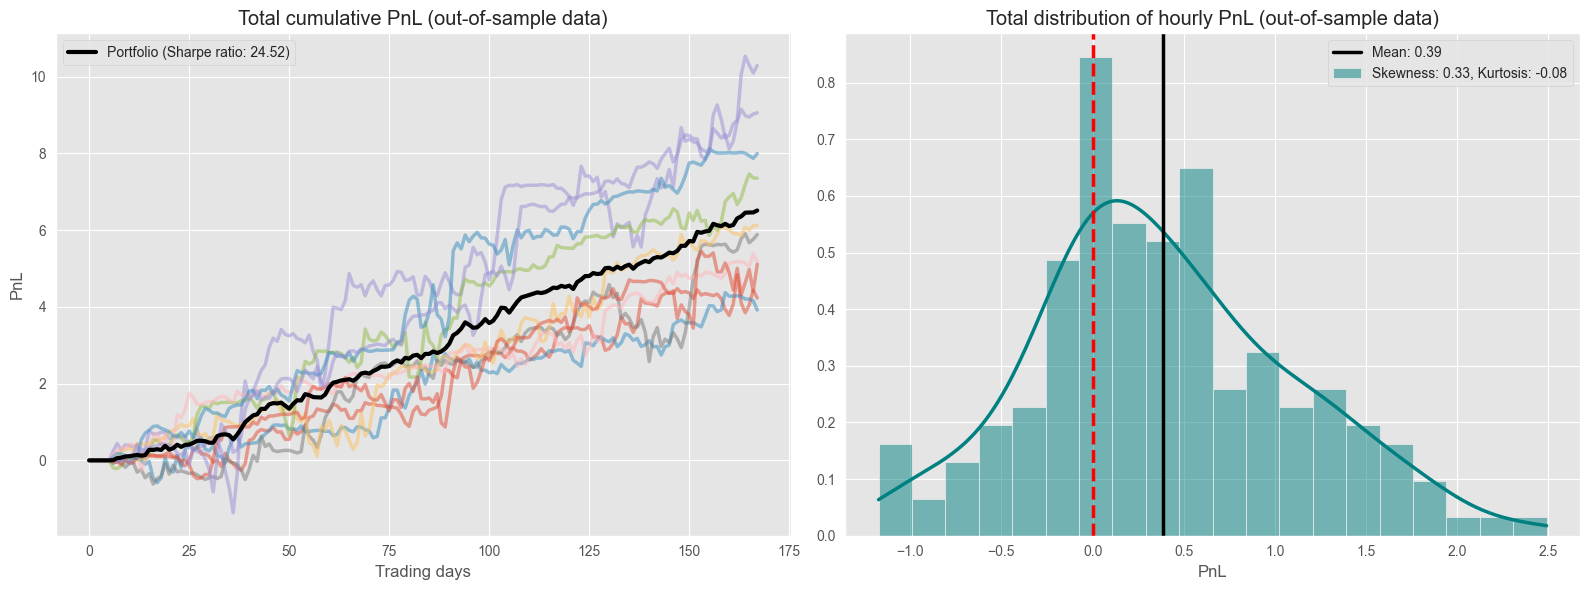

In [9]:
total_trading_assets = oos_H_pnl.shape[0]
oos_total_mean_return = torch.mean(oos_total_hourly_pnl)
oos_total_std_return = torch.std(oos_total_hourly_pnl)
oos_total_sharpe_ratio = oos_total_mean_return / oos_total_std_return * np.sqrt(rate)

# Calculate  statistics for hourly PnL
oos_H_pnl_mean = torch.mean(oos_total_hourly_pnl)
oos_H_pnl_std = torch.std(oos_total_hourly_pnl)
oos_H_pnl_skew = torch.mean((oos_total_hourly_pnl - oos_H_pnl_mean)**3) / oos_H_pnl_std**3
oos_H_pnl_kurtosis = torch.mean((oos_total_hourly_pnl - oos_H_pnl_mean)**4) / oos_H_pnl_std**4 - 3


fig, axes = plt.subplots(1,2, figsize=(16,6))  


for asset in range(total_trading_assets):
    axes[0].plot(torch.cumsum(oos_H_pnl[asset,:], dim=0), alpha=0.5)

norm_ptf_cum_pnl = oos_cumulative_pnl_portfolio / n_assets_for_trading
axes[0].plot(norm_ptf_cum_pnl, lw=3, color='black', label=f'Portfolio (Sharpe ratio: {oos_total_sharpe_ratio:.2f})')
axes[0].set_title("Total cumulative PnL (out-of-sample data)")
axes[0].set_xlabel("Trading days")
axes[0].set_ylabel("PnL")
axes[0].legend()


sns.histplot(oos_total_hourly_pnl, ax=axes[1], color='Teal', kde=True, bins=20, stat='density', label=f'Skewness: {oos_H_pnl_skew:.2f}, Kurtosis: {oos_H_pnl_kurtosis:.2f}')
axes[1].axvline(x=0, color='red', ls='--')
axes[1].axvline(x=oos_H_pnl_mean, color='black', label=f'Mean: {oos_H_pnl_mean:.2f}')
axes[1].set_title("Total distribution of hourly PnL (out-of-sample data)")
axes[1].set_xlabel("PnL")
axes[1].set_ylabel("")
axes[1].legend()


workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/pairtrading_perf_OOS.pdf', format='pdf')

plt.tight_layout()
plt.show()
